<a href="https://colab.research.google.com/github/AISaturdaysLagos/C9-team-solo-alie/blob/main/AiSaturdayLagos_Customer_Segmentation_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CUSTOMER SEGMENTATION PROJECT

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1mLSdWRzjSeCcaSxqkL-K5ThpbTENs0kW#scrollTo=8_7OgqfUpFPp)


A mid-sized retailer aims to replace one-size-fits-all campaigns with targeted growth. Using membership transactions, the business maintains Customer ID, Order ID, Order Date, Quantity, Unit Price and Total Amount. From these, i derive RFM features—Recency (days since last purchase), Frequency (distinct orders) and Monetary (total spend). After cleaning (date parsing, deduplication, removal of returns/negatives), RFM becomes a stable behavioral signal that replaces subjective scoring. The objective is to use unsupervised learning to group customers with similar purchasing patterns and translate each segment into actionable strategies—for example, VIP perks and early access for Champions, cross-sell bundles for Promising, and win-back offers for At-Risk or Hibernating customers. Method: run K-Means (and, if helpful, Gaussian Mixture Models), select the number of clusters with Elbow and Silhouette diagnostics, and profile segments by size and R/F/M levels.

In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import timedelta
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# Base folder

BASE = Path("/content") # if local. you can use: Path.cwd
OUT = BASE / "outputs"
FIG = OUT/ "figures"

# Create folders if they don't exist
OUT.mkdir(parents=True, exist_ok=True)
FIG.mkdir(parents=True, exist_ok=True)

In [4]:
#Import Online Retail Data containing transactions
online = pd.read_csv('/content/retail_sales_dataset.csv', encoding = 'unicode_escape')
online.head()

,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [5]:
SYNONYMS = {
    "customer_id": ["Customer ID", "Customer_Id"],
    "order_id":    ["Transaction ID"],
    "order_date":  ["Date"],
    "quantity":    ["Quantity"],
    "unit_price":  ["Unit Price", "Price per Unit", "Price"],
    "amount":      ["Total Amount", "Total"]
}

In [6]:
def auto_map_columns(df: pd.DataFrame, synonyms: dict) -> pd.DataFrame:
    rename_map = {}
    lower_cols = {c.lower(): c for c in df.columns}
    for target, alts in synonyms.items():
        for a in alts:
            if a in df.columns:
                rename_map[a] = target
                break
            if a.lower() in lower_cols:
                rename_map[lower_cols[a.lower()]] = target
                break
    return df.rename(columns=rename_map)

df = auto_map_columns(online.copy(), SYNONYMS)
df.columns

Index(['order_id', 'order_date', 'customer_id', 'Gender', 'Age',
       'Product Category', 'quantity', 'unit_price', 'amount'],
      dtype='object')

In [7]:
#Check the number of columns and rows in the dataset
online.shape

(1000, 9)

In [8]:
#Check for missing values in the dataset
online.isnull().sum(axis=0)

,0
Transaction ID,0
Date,0
Customer ID,0
Gender,0
Age,0
Product Category,0
Quantity,0
Price per Unit,0
Total Amount,0


In [9]:
required = ["customer_id","order_id","order_date","quantity"]
for col in required:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")

df["order_date"] = pd.to_datetime(df["order_date"], errors="coerce")
df["quantity"]   = pd.to_numeric(df["quantity"], errors="coerce")

has_amount    = "amount" in df.columns
has_unitprice = "unit_price" in df.columns


In [10]:
if not has_amount and not has_unitprice:
    raise ValueError("Need either 'amount' or 'unit_price' present (or mappable).")

if not has_amount and has_unitprice:
    df["unit_price"] = pd.to_numeric(df["unit_price"], errors="coerce")
    df["amount"] = df["quantity"] * df["unit_price"]

if has_amount and not has_unitprice:
    df["amount"] = pd.to_numeric(df["amount"], errors="coerce")
    denom = df["quantity"].replace(0, np.nan)
    df["unit_price"] = df["amount"] / denom

In [11]:
df = df.dropna(subset=["customer_id","order_id","order_date","quantity","amount"])
df = df[(df["quantity"] > 0) & (df["amount"] > 0)]
df["customer_id"] = df["customer_id"].astype(str)
df["order_id"]    = df["order_id"].astype(str)

df.head()

,order_id,order_date,customer_id,Gender,Age,Product Category,quantity,unit_price,amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [12]:
#Check the shape (number of columns and rows) in the dataset after data is cleaned
online.shape

(1000, 9)

In [13]:
print('Min:{}; Max:{}'.format(min(df.order_date),
max(df.order_date)))

Min:2023-01-01 00:00:00; Max:2024-01-01 00:00:00


## RFM (Recency , Frequency, Monetary) Computation

In [14]:
# "Today" snapshot = 1 day after the latest order in the dataset
snapshot = df["order_date"].max() + timedelta(days=1)

In [15]:
# Aggregate per customer

rfm = (
    df.groupby("customer_id").agg(
        last_purchase=("order_date","max"), # Most recent purchase date (Recency)
        orders_count=("order_id","nunique"),  # number of distinct orders (Frequecy)
        total_spend=("amount","sum") # total money spent (Monetary)
    )

    # Compute Recency in days: small = good (they bought recently)

    .assign(recency_days=lambda x: (snapshot - x["last_purchase"]).dt.days)

    # Drop helper column we no longer need

    .drop(columns="last_purchase")

    # Reorder colums for readabilty
    .loc[:, ["recency_days", "orders_count", "total_spend"]]
)

In [16]:

# Guard-rails: keep only valid customers
rfm = rfm[(rfm["recency_days"] >= 0) &  #recency cannot be negative
      (rfm["orders_count"] > 0) &  # must have at least 1 order
       (rfm["total_spend"] > 0) # and must have spent something
    ]

In [17]:
print("RFM column definitons:")
print (" - recency_days: days since the customer's last purchase (lower is better)")
print (" - orders_count: number of distinct orders per customer (higher is better)")
print (" - total_spend: total amount spent by the customer (dataset currency)")

print("\nSample (first 5 customers):")
display(rfm.head())

RFM column definitons:
 - recency_days: days since the customer's last purchase (lower is better)
 - orders_count: number of distinct orders per customer (higher is better)
 - total_spend: total amount spent by the customer (dataset currency)

Sample (first 5 customers):


,recency_days,orders_count,total_spend
customer_id,,,
CUST001,39,1,150
CUST002,309,1,1000
CUST003,354,1,30
CUST004,226,1,500
CUST005,241,1,100


In [18]:
print("\nDescriptive statistics:")
display(rfm.describe().rename(index={
    "count" : "count_customers",
    "mean" : "mean_value",
    "std" : "std_dev",
    "min" : "min_value",
    "25%" : "q1",
    "50%" : "median",
    "75%" : "q3",
    "max" : "max_value"
 }))


Descriptive statistics:


,recency_days,orders_count,total_spend
count_customers,1000.000000,1000.0,1000.000000
mean_value,182.982000,1.0,456.000000
std_dev,105.276773,0.0,559.997632
min_value,1.000000,1.0,25.000000
q1,90.000000,1.0,60.000000
median,186.500000,1.0,135.000000
q3,269.000000,1.0,900.000000
max_value,366.000000,1.0,2000.000000


## K search (Elbow & Silhouette), Choose best k

In [19]:
# Map colum names

col_map = {
    "recency_days": "recency" if "recency" in rfm.columns else "recency_days",
    "orders_count": "frequency" if "frequency" in rfm.columns else "orders_count",
    "total_spend":  "monetary" if "monetary" in rfm.columns else "total_spend"
}
for k, v in col_map.items():
    if v not in rfm.columns:
        raise KeyError(f"Expected RFM column not found: {v}")


In [20]:
# Build features matrix (R, F, M)

X = rfm[[col_map["recency_days"], col_map["orders_count"], col_map["total_spend"]]].copy()
X.columns = ["recency", "frequency", "monetary"] # standardize label for readability
# X.head()

In [21]:
# Transform & scale
X["monetary"] = np.log1p(X["monetary"]) # compress skew so cluster aren't dominated by big spenders
X_scaled = RobustScaler().fit_transform(X)

In [22]:
# Range of k and record metrics
ks = range(2,9)
inertias, silhouettes = [], [] # lists to collect metrics for each k
best_k, best_sil = None, -1 # track the best k and it silhouette

for k in ks:
  km = KMeans(n_clusters=k, n_init=20, random_state=42)
  labels = km.fit_predict(X_scaled)
  inertias.append(km.inertia_) # Elbow meteric: lower is bettter, but with diminishing returns

  try:
    sil = silhouette_score(X_scaled, labels) # Silhouette: -1..+1 where
  except Exception:
    sil = np.nan
  silhouettes.append(sil)

  if not np.isnan(sil) and sil > best_sil:
    best_k, best_sil = k, sil


print (f'Suggest best k (by Silhouette): {best_k} | Silhouteete = {best_sil:.4f}' if best_k else "No valid Silhouette found")

Suggest best k (by Silhouette): 4 | Silhouteete = 0.4581


In [23]:
# Making a compact result table
ksearch = pd.DataFrame({
    "k": list(ks),
    "inertia": inertias,
    "silhouette": silhouettes

})
display (ksearch.style.format({"inertia": "{:.4f}"}))


,k,inertia,silhouette
0,2,331.7122,0.397021
1,3,212.6850,0.424821
2,4,131.3456,0.458148
3,5,106.8027,0.416464
4,6,87.1126,0.407543
5,7,73.8378,0.392740
6,8,65.8047,0.392234


## Plot Elbow & Silhouette

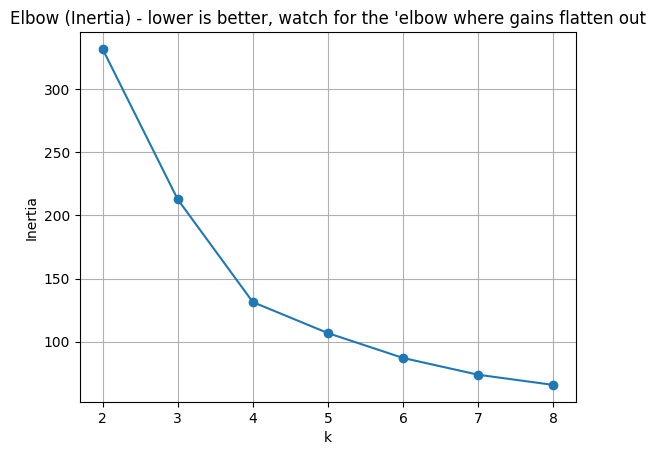

In [24]:
# Plot Elbow
plt.figure()
plt.plot(list(ks), inertias, marker="o")
plt.title("Elbow (Inertia) - lower is better, watch for the 'elbow where gains flatten out")
plt.xlabel("k");
plt.ylabel("Inertia");
plt.grid(True)
plt.savefig(FIG / "elbow.png", bbox_inches="tight");
plt.show()

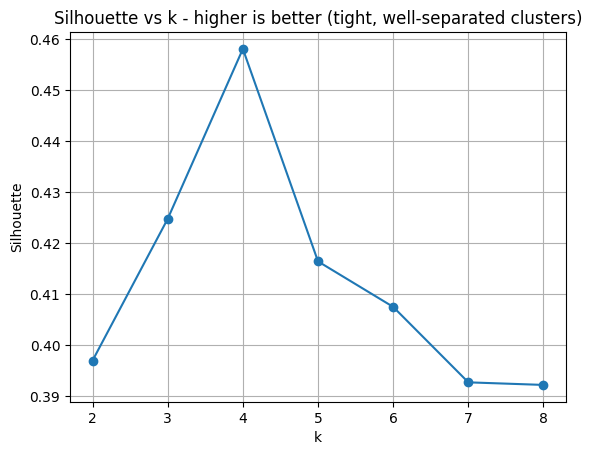

In [25]:
# Plot Silhouettes

plt.figure()
plt.plot(list(ks), silhouettes, marker="o")
plt.title("Silhouette vs k - higher is better (tight, well-separated clusters)")
plt.xlabel("k");
plt.ylabel("Silhouette");
plt.grid(True)
plt.savefig(FIG / "silhouettes.png", bbox_inches="tight");
plt.show()

In [26]:
# saving the k-search results as CSV (nice for appendix)

ksearch.to_csv(OUT / "KSEARCH.csv", index=False)

In [27]:
# Chart explanation

print("\nChart explanation:")
print("- Elbow (Inertia): 'I increase k until the improvement (drop in inertia) flattens - that's the elbow'")
print ("- Silhouette: 'I choose the k with the highest score, meaning clusters are compact and well-separated'")
if best_k:
  print (f"\nDecision: I will proceed with k={best_k} (best Silhouette={best_sil:.4f}) and verify it also makes business sense.")



Chart explanation:
- Elbow (Inertia): 'I increase k until the improvement (drop in inertia) flattens - that's the elbow'
- Silhouette: 'I choose the k with the highest score, meaning clusters are compact and well-separated'

Decision: I will proceed with k=4 (best Silhouette=0.4581) and verify it also makes business sense.


Final KMean wth best_k

In [28]:
# Choose the final number of clusters

k_final = best_k if best_k is not None else 3

# Fit KMeans again but this time for real, with chosen k

km = KMeans(n_clusters=k_final, n_init=20, random_state=42).fit(X_scaled)

# Make a copy of the RFM table (to keep  original data safe)
rfm = rfm.copy()

# Add each customer's cluster label (segment number)
# Example: 0, 1, 2, 3, ...... depending on which group they belong to

rfm["segment"] = km.labels_

In [29]:
col_map = {
    "recency": "recency" if "recency" in rfm.columns else "recency_days",
    "frequency": "frequency" if "frequency" in rfm.columns else "orders_count",
    "monetary": "monetary" if "monetary" in rfm.columns else "total_spend"
}

for want, have in col_map.items():
    if have not in rfm.columns:
        raise KeyError(f"Expected RFM column not found: want '{want}' mapped to '{have}' ")

In [30]:
rfm_std = rfm.rename(columns ={
    col_map["recency"]: "recency",
    col_map["frequency"]: "frequency",
    col_map["monetary"]: "monetary"
}).copy()

Summary of each segment

In [31]:
summary = (
    rfm_std.groupby("segment")
    .agg(
        size = ("segment", "size"), # how many customers in the group
        recency_mean = ("recency", "mean"), # average recency (how recently they bought)
        frequency_mean = ("frequency", "mean"), # average frequency (how often they buy)
        moneytary_mean = ("monetary", "mean"), # average monetary (how much they spend)
    )
    .assign(size_pct = lambda d: 100 * d["size"] / d["size"].sum()) # percentage of total
    .sort_values("size", ascending=False)                           # biggest group first
    .round({"recency_mean": 1, "frequency_mean": 2, "moneytary_mean": 2, "size_pct": 2})
)

GIVE EACH CLUSTER A HUMAN-READABLE PERSONA NAME

In [32]:
from os import name
# Rank clusters by R/F/M - Recenct lower is better, Frequency & Monetary higher are better.

# Rank by recency (lower = better)
r_rank = rfm_std.groupby("segment")["recency"].mean().rank(ascending=True)

# Rank by frequency (higher = better)
f_rank = rfm_std.groupby("segment")["frequency"].mean().rank(ascending=False)

# Rank by monetary (higher = better)
m_rank = rfm_std.groupby("segment")["monetary"].mean().rank(ascending=False)


# Combine the three ranks into a single score
score = (r_rank + f_rank + m_rank).sort_values()


# Assign names to segments based on overall score

persona_map = {
    seg: name for seg, name in zip(
        score.index,
        ["Champions", "Loyal", "Promising", " At Risk", "Hibernating"]
    )
}

# Apply these names to your dataset
rfm_std["persona"] = rfm_std["segment"].map(persona_map)
summary["persona"] = summary.index.map(persona_map)

#  Display the summary table - your final segnmentation profile

summary

,size,recency_mean,frequency_mean,moneytary_mean,size_pct,persona
segment,,,,,,
0,307,273.7,1.0,86.69,30.7,At Risk
1,297,91.7,1.0,89.18,29.7,Promising
3,203,271.3,1.0,1036.45,20.3,Loyal
2,193,86.3,1.0,997.41,19.3,Champions


Save outputs (CSVs + figures) and quick bar chart

In [40]:
# Standardize RFM column names (maps whatever you used in Step 4) ---
col_map = {
    "recency":   "recency"     if "recency"     in rfm.columns else "recency_days",
    "frequency": "frequency"   if "frequency"   in rfm.columns else "orders_count",
    "monetary":  "monetary"    if "monetary"    in rfm.columns else "total_spend",
}
for want, have in col_map.items():
    if have not in rfm.columns:
        raise KeyError(f"Expected RFM column not found: want '{want}' mapped to '{have}'. "
                       f"Your columns: {rfm.columns.tolist()}")

# Create a standardized copy with columns named recency/frequency/monetary
rfm_std = rfm.rename(columns={
    col_map["recency"]: "recency",
    col_map["frequency"]: "frequency",
    col_map["monetary"]: "monetary"
}).copy()

# Ensure index is named customer_id for clarity
if rfm_std.index.name != "customer_id":
    rfm_std.index.name = "customer_id"



# Build SEGMENTS using a MERGE on customer_id
left  = rfm_std.reset_index()[["customer_id", "recency", "frequency", "monetary"]]
right = rfm[["segment"]].reset_index()  # segment (and persona) live on original rfm

if "persona" in rfm.columns:
    right = rfm[["segment", "persona"]].reset_index()

segments = left.merge(right, on="customer_id", how="left")

# Optional: order columns nicely
cols = ["customer_id", "segment"]
if "persona" in segments.columns:
    cols.append("persona")
cols += ["recency", "frequency", "monetary"]
segments = segments[cols]

# segments.to_csv(OUT/ "SEGMENTS.csv", index=False)

# Save segment summary table
# summary.to_csv(OUT/ "SEGMENT_SUMMARY.csv")

# Save K Search table (Elbow & Silhouette across tested k)
pd.DataFrame({
    "k": list(ks),
    "inertia": inertias,
    "silhouette": silhouettes
}).to_csv(OUT / "KSEARCH.csv", index=False)

# print("\nSaved files:")
# print(" -", OUT / "SEGMENTS.csv")
# print(" -", OUT / "SEGMENT_SUMMARY.csv")
# print(" -", OUT / "KSEARCH.csv")
# print(" -", FIG / "elbow.png")
# print(" -", FIG / "silhouette.png")

segments.head()


Saved files:
 - /content/outputs/SEGMENTS.csv
 - /content/outputs/SEGMENT_SUMMARY.csv
 - /content/outputs/KSEARCH.csv
 - /content/outputs/figures/elbow.png
 - /content/outputs/figures/silhouette.png


,customer_id,segment,recency,frequency,monetary
0,CUST001,1,39,1,150
1,CUST002,3,309,1,1000
2,CUST003,0,354,1,30
3,CUST004,3,226,1,500
4,CUST005,0,241,1,100


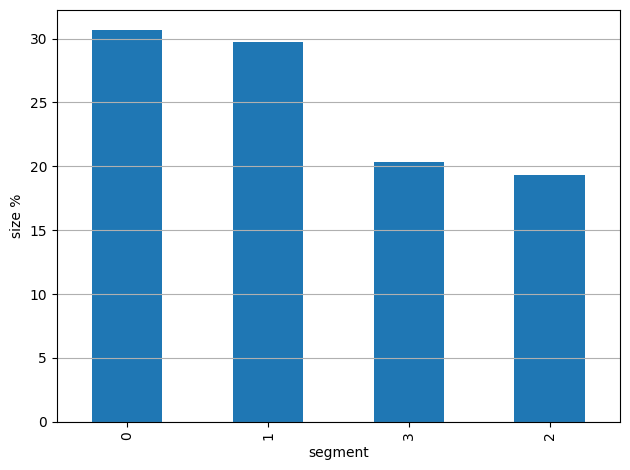

- /content/outputs/figures/segment_sizes.png


In [38]:
# Segment size bar chart

plt.figure()
summary["size_pct"].plot(kind="bar")
plt.xlabel("segment")
plt.ylabel("size %")
plt.grid(axis="y")
plt.tight_layout()
plt.savefig(FIG / "segment_size.png")
plt.show()

print("-", FIG/ "segment_sizes.png")